In [0]:
!git clone https://github.com/pierluigiferrari/ssd_keras

In [0]:
!git clone https://gitlab.com/xuananh.do1998/datasets

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

In [0]:
%cd ssd_keras

In [0]:
from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from eval_utils.average_precision_evaluator import Evaluator

In [0]:
img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 1 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales_coco = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # The anchor box scaling factors used in the original SSD300 for the MS COCO datasets
scales = scales_pascal
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

In [0]:
K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                swap_channels=swap_channels)

# Load best trained weights into the model.
weights_path = '/content/datasets/VGG_ILSVRC_16_layers_fc_reduced.h5'

model.load_weights(weights_path, by_name=True)

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss, metrics=['accuracy'])
model.load_weights('/content/drive/My Drive/Colab Notebooks/check_point_model_b64_e20_i1000.hdf5', by_name=True)

In [0]:
model_path = '/content/drive/My Drive/Colab Notebooks/check_point_model_b512_e20_i1000'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'compute_loss': ssd_loss.compute_loss})

In [0]:
train_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)

# The directories that contain the images.
images_dir      = '/content/datasets/Datasets_64/JPEGImages'

# The directories that contain the annotations.
annotations_dir      = '/content/datasets/Datasets_64/Annotations'

# The paths to the image sets.
train_image_set_filename    = '/content/datasets/Datasets_64/ImageSets/Main/train.txt'
val_image_set_filename      = '/content/datasets/Datasets_64/ImageSets/Main/val.txt'
trainval_image_set_filename = '/content/datasets/Datasets_64/ImageSets/Main/trainval.txt'
test_image_set_filename     = '/content/datasets/Datasets_64/ImageSets/Main/test.txt'

# Class names to look for and order to map them to integers.
classes = ['background', 'ship']

train_dataset.parse_xml(images_dirs=[images_dir],
                        image_set_filenames=[trainval_image_set_filename],
                        annotations_dirs=[annotations_dir],
                        classes=classes,
                        include_classes='all',
                        exclude_truncated=False,
                        exclude_difficult=False,
                        ret=False)

val_dataset.parse_xml(images_dirs=[images_dir],
                      image_set_filenames=[test_image_set_filename],
                      annotations_dirs=[annotations_dir],
                      classes=classes,
                      include_classes='all',
                      exclude_truncated=False,
                      exclude_difficult=True,
                      ret=False)

train_dataset.create_hdf5_dataset(file_path='dataset_pascal_voc_07+12_trainval.h5',
                                  resize=(300,300),
                                  variable_image_size=True,
                                  verbose=True)

val_dataset.create_hdf5_dataset(file_path='dataset_pascal_voc_07_test.h5',
                                resize=(300,300),
                                variable_image_size=True,
                                verbose=True)

In [0]:
# Set the batch size.

batch_size = 64

# Set the image transformations for pre-processing and data augmentation options.

# For the training generator:
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv4_3_norm_mbox_conf').output_shape[1:3],
                   model.get_layer('fc7_mbox_conf').output_shape[1:3],
                   model.get_layer('conv6_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv7_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv8_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv9_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

In [0]:
# Define a learning rate schedule.

def lr_schedule(epoch):
    if epoch < 80:
        return 0.001
    elif epoch < 100:
        return 0.0001
    else:
        return 0.00001

In [0]:
# Define model callbacks.

filepath = '/content/drive/My Drive/Colab Notebooks/add_acc.hdf5'
model_checkpoint = ModelCheckpoint(filepath,
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)
# model_checkpoint.best = load

csv_logger = CSVLogger(filename='ssd300_training_log.csv',
                       separator=',',
                       append=True)

learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule,
                                                verbose=1)

terminate_on_nan = TerminateOnNaN()

callbacks = [model_checkpoint,
             csv_logger,
             learning_rate_scheduler,
             terminate_on_nan]


In [0]:
initial_epoch   = 0
final_epoch     = 5
steps_per_epoch = 500

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)

288/500 [================>.............] - ETA: 8:25 - loss: 4.9440 - acc: 0.3691

In [0]:
# PREDICT
# Set the generator for the predictions.

predict_generator = val_dataset.generate(batch_size=64,
                                         shuffle=True,
                                         transformations=[convert_to_3_channels,
                                                          resize],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'filenames',
                                                  'inverse_transform',
                                                  'original_images',
                                                  'original_labels'},
                                         keep_images_without_gt=False)

In [0]:
# Generate samples.

batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(predict_generator)

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))

In [0]:
# Make predictions.

y_pred = model.predict(batch_images)

In [0]:
# Decode the raw predictions in `y_pred`.

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.4,
                                   top_k=20,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

In [0]:
# Convert the predictions for the original image.

y_pred_decoded_inv = apply_inverse_transforms(y_pred_decoded, batch_inverse_transforms)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded_inv[i])

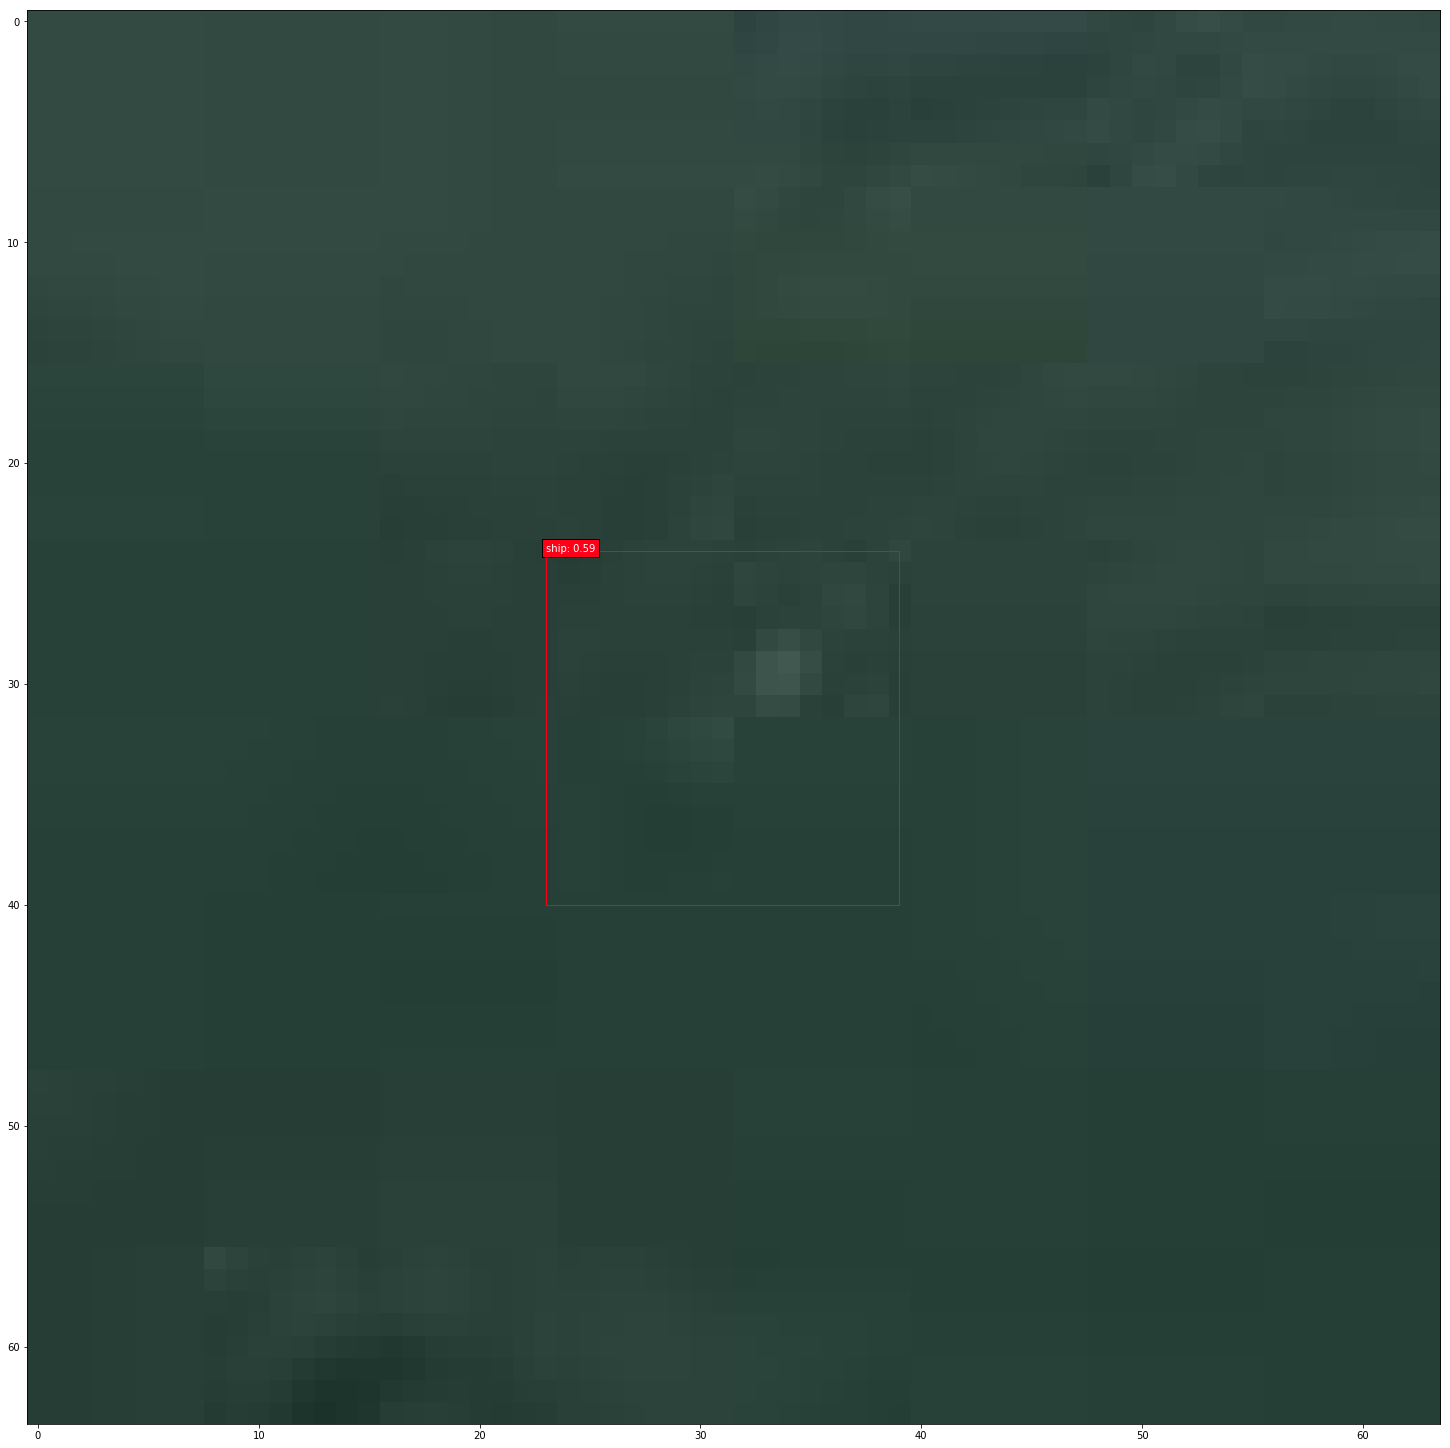

In [87]:
# Draw the predicted boxes onto the image

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()
classes = ['background', 'ship']

plt.figure(figsize=(26,26))
plt.imshow(batch_original_images[i])

current_axis = plt.gca()

# for box in batch_original_labels[i]:
#     xmin = box[1]
#     ymin = box[2]
#     xmax = box[3]
#     ymax = box[4]
#     label = '{}'.format(classes[int(box[0])])
#     current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=1))  
#     current_axis.text(xmin, ymin, label, size='medium', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_decoded_inv[i]:
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=1))  
    current_axis.text(xmin, ymin, label, size='medium', color='white', bbox={'facecolor':color, 'alpha':1.0})

In [0]:
# EVALUATE
model_mode = 'inference'
model_path = '/content/ssd_keras/best_weght.hdf5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'DecodeDetections': DecodeDetections,
                                               'compute_loss': ssd_loss.compute_loss})



In [0]:
evaluator = Evaluator(model=model,
                      n_classes=n_classes,
                      data_generator=val_dataset,
                      model_mode=model_mode)

results = evaluator(img_height=img_height,
                    img_width=img_width,
                    batch_size=8,
                    data_generator_mode='resize',
                    round_confidences=False,
                    matching_iou_threshold=0.5,
                    border_pixels='include',
                    sorting_algorithm='quicksort',
                    average_precision_mode='sample',
                    num_recall_points=11,
                    ignore_neutral_boxes=True,
                    return_precisions=True,
                    return_recalls=True,
                    return_average_precisions=True,
                    verbose=True)

mean_average_precision, average_precisions, precisions, recalls = results

In [0]:

for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(classes[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

In [0]:
m = max((n_classes + 1) // 2, 2)
n = 2

fig, cells = plt.subplots(m, n, figsize=(n*8,m*8))
for i in range(m):
    for j in range(n):
        if n*i+j+1 > n_classes: break
        cells[i, j].plot(recalls[n*i+j+1], precisions[n*i+j+1], color='blue', linewidth=1.0)
        cells[i, j].set_xlabel('recall', fontsize=14)
        cells[i, j].set_ylabel('precision', fontsize=14)
        cells[i, j].grid(True)
        cells[i, j].set_xticks(np.linspace(0,1,11))
        cells[i, j].set_yticks(np.linspace(0,1,11))
        cells[i, j].set_title("{}, AP: {:.3f}".format(classes[n*i+j+1], average_precisions[n*i+j+1]), fontsize=16)